<a href="https://colab.research.google.com/github/adenurchalisa/Capstone-Model/blob/main/model_prediksi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [2]:
# 1. Mount Google Drive (jika di Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 2. Baca dataset (ganti path sesuai lokasi file di Drive kamu)
file_path = '/content/drive/MyDrive/capstoneku/data_transaksi_advanced.csv'
df = pd.read_csv(file_path)
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [4]:
# 3. Drop kolom yang tidak dipakai (menyesuaikan preprocessing klasifikasi)
df = df.drop(columns=['rating', 'anomaly_flag', 'id_transaksi'])

In [5]:
# 4. Feature time engineering
df['bulan'] = df['tanggal'].dt.month
df['tahun'] = df['tanggal'].dt.year
df['hari'] = df['tanggal'].dt.day
df['hari_ke'] = df['tanggal'].dt.dayofweek
df['jam'] = pd.to_datetime(df['waktu'], format='%H:%M').dt.hour

df = df.drop(columns=['tanggal', 'waktu'])


In [6]:
# 5. Encoding fitur kategorikal
le_profil = LabelEncoder()
df['profil_enc'] = le_profil.fit_transform(df['profil'])

le_mp = LabelEncoder()
df['metode_pembayaran_enc'] = le_mp.fit_transform(df['metode_pembayaran'])

le_lokasi = LabelEncoder()
df['lokasi_enc'] = le_lokasi.fit_transform(df['lokasi'])

le_tipe = LabelEncoder()
df['tipe_enc'] = le_tipe.fit_transform(df['tipe'])

In [7]:
# 6. Filter hanya transaksi keluar (pengeluaran)
idx_keluar = df['tipe'] == 'keluar'
df_pengeluaran = df[idx_keluar].copy()

In [8]:
# 7. Agregasi per user per bulan
grouped = df_pengeluaran.groupby(['user_id', 'tahun', 'bulan']).agg(
    total_pengeluaran=('nominal', 'sum'),
    jumlah_transaksi=('nominal', 'count'),
    rata2_transaksi=('nominal', 'mean'),
    profil_enc=('profil_enc', 'first'),
    metode_pembayaran_enc=('metode_pembayaran_enc', lambda x: x.mode()[0] if len(x) else 0),
    lokasi_enc=('lokasi_enc', lambda x: x.mode()[0] if len(x) else 0)
).reset_index()

In [9]:
# 8. Buat target prediksi: total_pengeluaran bulan berikutnya (per user)
grouped = grouped.sort_values(['user_id', 'tahun', 'bulan'])
grouped['target'] = grouped.groupby('user_id')['total_pengeluaran'].shift(-1)

In [10]:
# 9. Drop baris target kosong (bulan terakhir tiap user)
grouped = grouped.dropna(subset=['target']).reset_index(drop=True)

In [11]:
# 10. Split data: train = tahun < 2024, test = tahun == 2024
train = grouped[grouped['tahun'] < 2024]
test = grouped[grouped['tahun'] == 2024]

fitur = [
    'total_pengeluaran', 'jumlah_transaksi', 'rata2_transaksi',
    'profil_enc', 'metode_pembayaran_enc', 'lokasi_enc', 'bulan'
]

X_train = train[fitur]
y_train = train['target']
X_test = test[fitur]
y_test = test['target']

In [12]:
# 11. Model training
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [13]:
# 12. Prediksi & evaluasi
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 6445904.36
RMSE: 9952715.89


In [16]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 701.08%


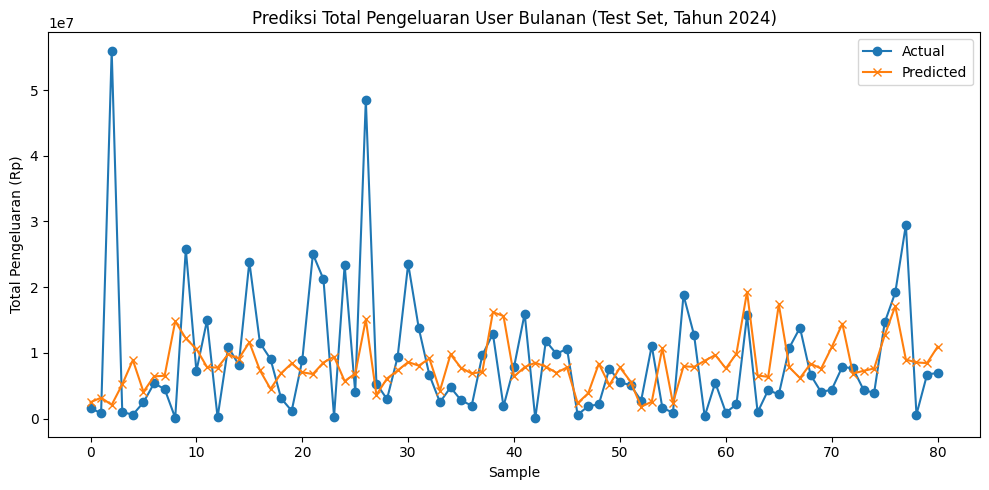

In [14]:
# 13. Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('Prediksi Total Pengeluaran User Bulanan (Test Set, Tahun 2024)')
plt.xlabel('Sample')
plt.ylabel('Total Pengeluaran (Rp)')
plt.tight_layout()
plt.show()

In [15]:
# 14. (Opsional) Simpan model dan encoder jika mau dipakai ulang
joblib.dump(model, '/content/drive/MyDrive/regresi_pengeluaran_bulanan_rf.joblib')
joblib.dump(le_profil, '/content/drive/MyDrive/le_profil.joblib')
joblib.dump(le_mp, '/content/drive/MyDrive/le_metode_pembayaran.joblib')
joblib.dump(le_lokasi, '/content/drive/MyDrive/le_lokasi.joblib')

['/content/drive/MyDrive/le_lokasi.joblib']